<a href="https://colab.research.google.com/github/nishka-s26/mediacontentatlaslongitudinal/blob/main/Copy_of_Media_Content_Atlas_Lightweight_Tutorial_for_Colab_T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📲🗺️ Media Content Atlas – Lightweight Example Code for the Pipeline

## 🔍 Quick Recap – What is MCA?

Media Content Atlas (MCA) is an AI-powered pipeline and interactive dashboard for large-scale analysis of media experiences. It goes beyond basic screen-time metrics to analyze what content people actually see and engage with across apps.

👉 Check these out if you haven’t already:
*   🌐 [Website](https://mediacontentatlas.github.io/)
*   📄 [Preprint](https://arxiv.org/abs/2504.16323)
*   💻[Github Repo](https://github.com/mediacontentatlas/mediacontentatlas/tree/main)

⸻

## 📁 What’s this Colab about?

This tutorial walks through a lightweight version of the Media Content Atlas pipeline using quantized models and a small sample dataset that we’re allowed to share publicly.

In a typical Screenome dataset, each participant contributes thousands of timestamped smartphone screenshots, a log CSV file, and sometimes relevant survey data. In this example, we’ll focus only on the images.

⚠️ Note: For the full-scale pipeline used in our paper (1.12M screenshots), we used A100 GPUs and optimized for batching— so this Colab is a simplified version. For full details on scaling and setup, see the GitHub repo.

# Media Content Atlas Pipeline
<img src="https://github.com/mediacontentatlas/mediacontentatlas/blob/main/assets/mcapipeline.png?raw=true" alt="MCA Pipeline" width="800"/>

## 📌 READ ME Before Running the Code

⚠️ Heads up: On Colab's free GPU, generating descriptions and embeddings can take a while — even with just 350 images. So, the tutorial runtime is around ~3 hours.

⏩ If you’d rather skip ahead and use precomputed outputs, jump to the “Do Clustering + Topic Modeling” section.

🧪 But if you want to experience the full pipeline in action, including screen processing and LLM-based description generation — follow along from the top!

Ready? Let’s go! 🚀


In [ ]:
import torch

if not torch.cuda.is_available():
    raise RuntimeError("⚠️ GPU not available. Go to Runtime > Change runtime type > select GPU.")

print("✅ GPU is available:", torch.cuda.get_device_name(0))

✅ GPU is available: Tesla T4


## Download Images

Downloading...
From (original): https://drive.google.com/uc?id=1jHiObq9EMjPF8ptgK8_I5TM4YnnueO5e
From (redirected): https://drive.google.com/uc?id=1jHiObq9EMjPF8ptgK8_I5TM4YnnueO5e&confirm=t&uuid=54ba4f46-c3f9-4a43-b455-e57160d4fdad
To: /content/MCA_tutorial_images.tar.gz
100%|██████████| 185M/185M [00:00<00:00, 250MB/s]


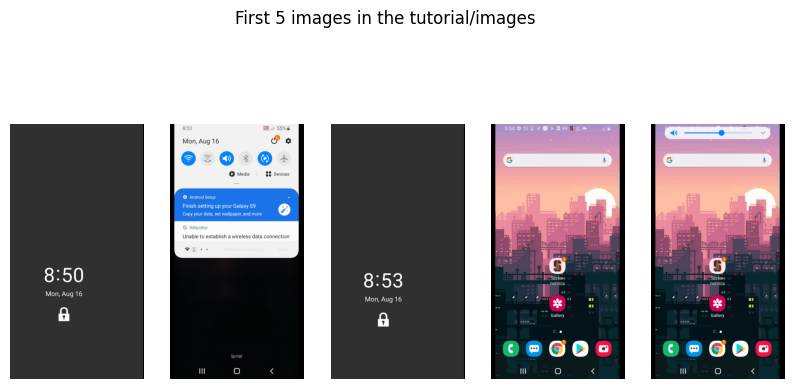

In [ ]:
import os
import tarfile
import gdown
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Download .tar.gz using gdown
file_id = "1jHiObq9EMjPF8ptgK8_I5TM4YnnueO5e"
output_file = "MCA_tutorial_images.tar.gz"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(output_file):
    print("Downloading from Google Drive...")
    gdown.download(gdrive_url, output_file, quiet=False)

# Step 2: Extract the .tar.gz
extract_path = "tutorial/images"
if not os.path.exists(extract_path):
    print("Extracting archive...")
    with tarfile.open(output_file, "r:gz") as tar:
        tar.extractall(path=".")

# Step 3: Show a couple of images
image_files = sorted([
    f for f in os.listdir(extract_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith("._")
])

n_images = min(5, len(image_files))
plt.figure(figsize=(10, 5))

for i in range(n_images):
    img_path = os.path.join(extract_path, image_files[i])
    img = Image.open(img_path)
    plt.subplot(1, n_images, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("First 5 images in the tutorial/images")
plt.show()

In [ ]:
!rm -rf MCA_tutorial_images.tar.gz

## Generate Screen Embeddings

In [ ]:
!pip install open_clip_torch

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import open_clip

# --- Step 1: Load CLIP ViT-L/14 ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')
model = model.to(device).eval()

# --- Step 2: Embed all images in tutorial/images ---
image_folder = "tutorial/images"
image_files = sorted([
    f for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

embeddings = []
filenames = []

with torch.no_grad():
    for fname in tqdm(image_files, desc="Embedding images"):
        try:
            image_path = os.path.join(image_folder, fname)
            image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
            emb = model.encode_image(image)
            emb = emb / emb.norm(dim=-1, keepdim=True)  # Normalize
            embeddings.append(emb.cpu().numpy())
            filenames.append(fname)
        except Exception as e:
            print(f"Error processing {fname}: {e}") #if there are any problem with the image file, note and continue.

# --- Step 3: Save as .npz ---
embeddings_array = np.concatenate(embeddings, axis=0)  # Shape: (N, D)
np.savez_compressed("tutorial/clip_embeddings.npz", filenames=np.array(filenames), embeddings=embeddings_array)

print("✅ Embeddings saved to tutorial/clip_embeddings.npz")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Embedding images: 100%|██████████| 353/353 [00:31<00:00, 11.06it/s]

✅ Embeddings saved to tutorial/clip_embeddings.npz


## Generate Screen Descriptions

Just a heads up, this section takes around 2 hours if you use all the image data I provided. You can set things up and leave it running while generating descriptions.

If you want to skip this part, you can go to **📌Checkpoint before Clustering** section, and download the descriptions and embeddings from my latest run.



In [ ]:
!pip install -U transformers==4.48.1

**Restart session after running the above snippet. (Runtime -> Restart Session)**

In [ ]:
!pip install bitsandbytes accelerate

**If you don't know what to do about the snippet below:** To create a Huggingface Token, you need to have [a Huggingface account](https://huggingface.co/) and [generate a write access token for the notebook](https://huggingface.co/docs/hub/en/security-tokens.)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()  #we need to login to huggingface to use the llava onevision model

In [ ]:
import os
import torch
import logging
from PIL import Image, ImageFile

# Allow truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# === Paths and Config ===
image_folder = "tutorial/images"
output_file = "tutorial/llava_descriptions.csv"

# Performance settings
batch_size = 2  # Safe for Colab T4
max_new_tokens = 100
max_image_size = 1024
num_workers = 2
prefetch_factor = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Logging
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "llava_inference.log"),
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

print("✅ Setup complete. Ready to load model.")

✅ Setup complete. Ready to load model.


In [ ]:
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig
import torch

# Specify your model id
model_id = "llava-hf/llava-onevision-qwen2-7b-si-hf"

# Configure 4-bit quantization for T4, using BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                              # Enables 4-bit quantization
    bnb_4bit_compute_dtype=torch.float16,           # Use float16 for compute
    bnb_4bit_use_double_quant=True,                 # Enable double quantization for better accuracy
    bnb_4bit_quant_type="nf4"                       # Use the nf4 quantization type
)

# Load processor and model (set trust_remote_code=True if required by the model)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)
processor.tokenizer.padding_side = "left"
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    trust_remote_code=True
).eval()

print("✅ LLaVA-One-Vision model loaded in 4-bit for:", model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/178 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/428 [00:00<?, ?B/s]

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


config.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/78.0k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

✅ LLaVA-One-Vision model loaded in 4-bit for: llava-hf/llava-onevision-qwen2-7b-si-hf


In [ ]:
import gc
import csv
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# === Prompt, you can change it for your use case. ===
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Describe this screenshot in detail, using this output format: The screenshot displays [the content goes here, including verbatim text if present, or a specific description of what the text is about; if there is an image, describe exactly what it depicts]. Focus on explaining the exact content of any text or image. Include the app name if identifiable, but DO NOT include quantitative details, such as likes or status bar information."}
        ],
    }
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

# === Dataset for on-the-fly loading ===
class ImageTextDataset(Dataset):
    def __init__(self, image_paths, prompt_text, max_size=1024):
        self.image_paths = image_paths
        self.prompt = prompt_text
        self.max_size = max_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        w, h = image.size
        scale = max(w, h) / self.max_size if max(w, h) > self.max_size else 1
        image = image.resize((int(w / scale), int(h / scale)), Image.Resampling.LANCZOS)
        return path, image, self.prompt

# === Collator ===
def collate_fn(batch):
    paths, images, prompts = zip(*batch)
    inputs = processor(list(images), list(prompts), return_tensors="pt", padding=True)
    inputs["paths"] = paths
    return inputs

# === Load image paths and skip completed ===
image_paths = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith("._")
])

already_done = set()
if os.path.exists(output_file):
    with open(output_file, newline='') as f:
        reader = csv.reader(f)
        next(reader, None)
        for row in reader:
            already_done.add(row[0])

image_paths = [p for p in image_paths if os.path.basename(p) not in already_done]
print(f"🖼️ {len(image_paths)} images to process")

# === DataLoader ===
dataset = ImageTextDataset(image_paths, prompt, max_size=max_image_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor)

# === Inference Loop ===
with open(output_file, mode='a', newline='') as f:
    writer = csv.writer(f)
    if len(already_done) == 0:
        writer.writerow(["filename", "description"])

    with torch.inference_mode():
        for batch in tqdm(dataloader, desc="Describing screenshots"):
            try:
                inputs = {k: v.to(device) for k, v in batch.items() if k != "paths"}
                outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
                decoded = processor.batch_decode(outputs, skip_special_tokens=True)

                for path, desc in zip(batch["paths"], decoded):
                    cleaned = desc.split("assistant")[-1].strip()
                    writer.writerow([os.path.basename(path), cleaned])
                    f.flush()

                torch.cuda.empty_cache()
                gc.collect()

            except Exception as e:
                logging.warning(f"❌ Error in batch: {e}")
                for path in batch.get("paths", []):
                    logging.warning(f"Skipped: {os.path.basename(path)}")

🖼️ 343 images to process


Describing screenshots: 100%|██████████| 172/172 [1:33:55<00:00, 32.76s/it]


### Let's look at the descriptions

The model, prompt, image size, quantization, hyperparameters, etc. all affect the results. So you can do some prompt engineering, hyperparameter optimization and finetuning based on your data.

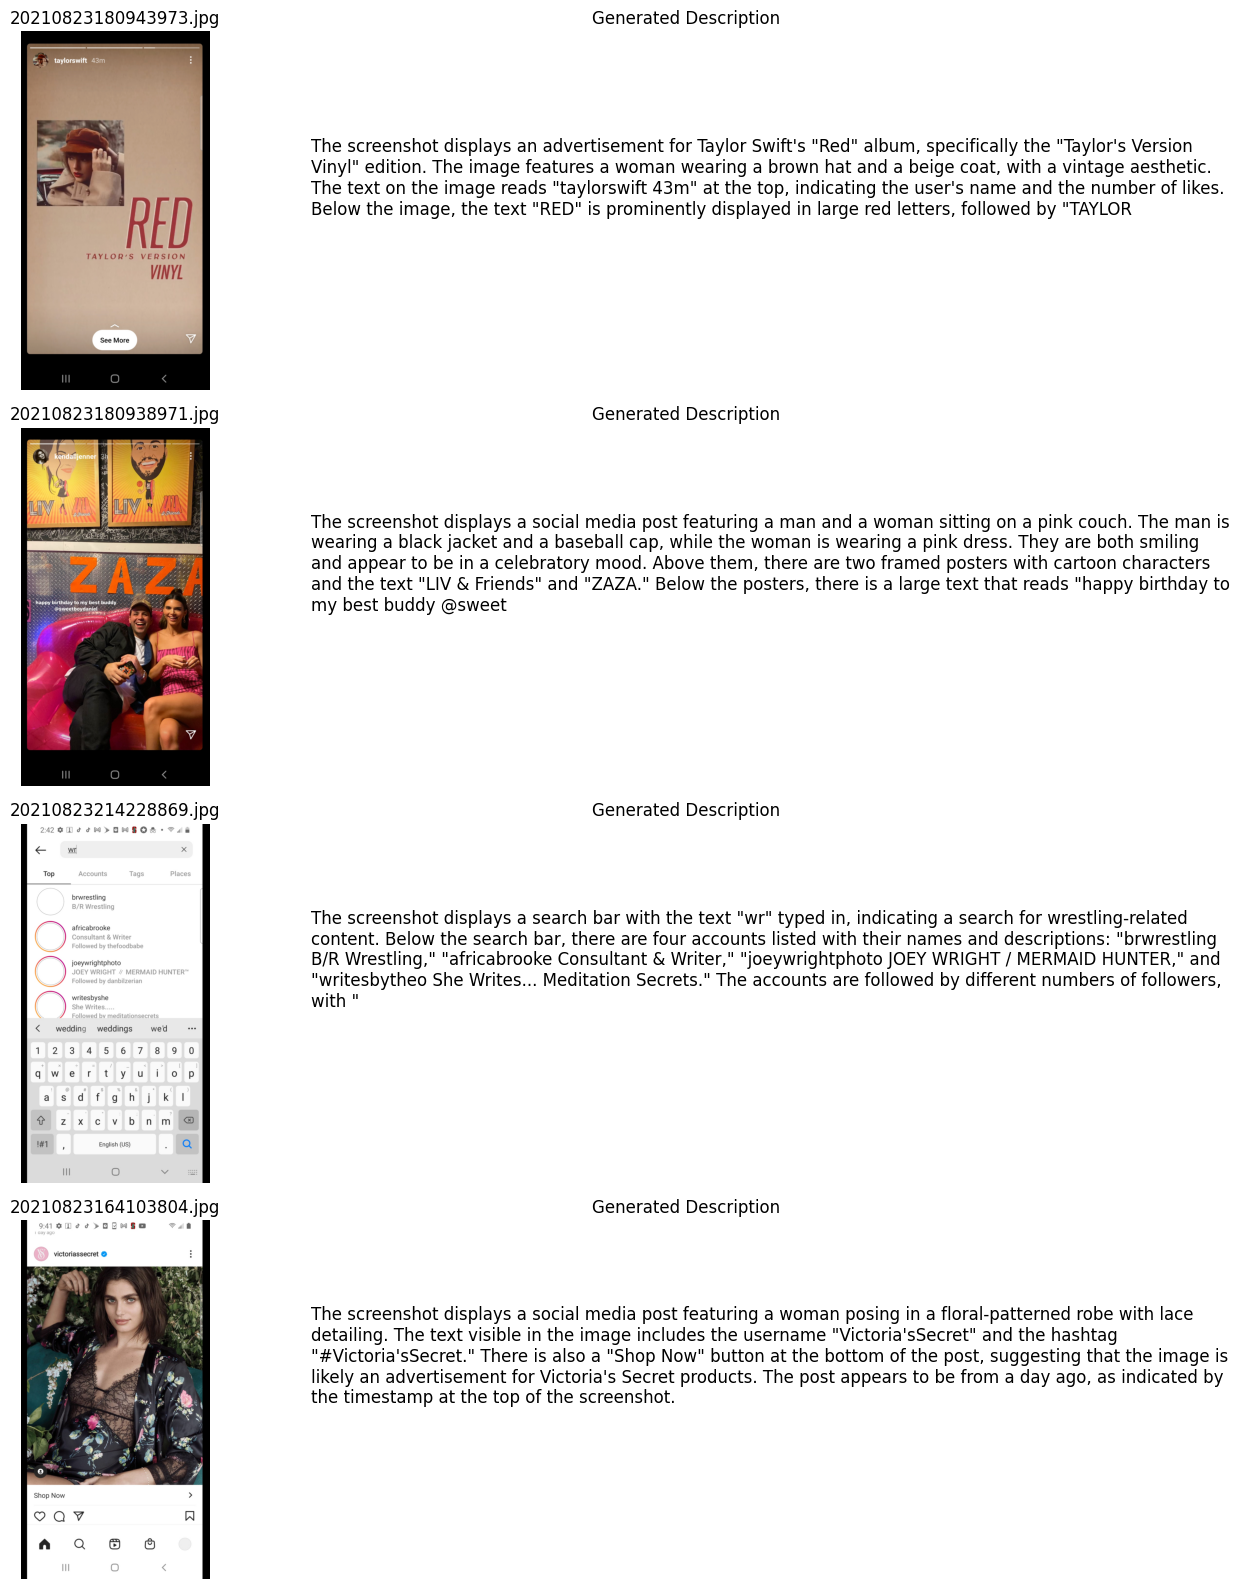

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Load descriptions
df = pd.read_csv("tutorial/llava_descriptions.csv")

# Show N random examples
n = 4
samples = df.sample(n)

plt.figure(figsize=(15, 4 * n))

for i, row in enumerate(samples.itertuples(), 1):
    img_path = os.path.join("tutorial/images", row.filename)
    img = Image.open(img_path).convert("RGB")

    plt.subplot(n, 2, 2 * i - 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{row.filename}", fontsize=12)

    plt.subplot(n, 2, 2 * i)
    plt.text(0, 0.5, row.description, fontsize=12, wrap=True)
    plt.axis("off")
    plt.title("Generated Description", fontsize=12)

plt.tight_layout()
plt.show()

## Generate Screen Description Embeddings

In [ ]:
!pip install -q sentence-transformers

In [ ]:
# === Clean previous LLaVA model from memory
try:
    del model
    del processor
    torch.cuda.empty_cache()
    import gc
    gc.collect()
    print("🧹 Cleared previous LLaVA model and processor from memory.")
except:
    print("⚠️ No LLaVA model loaded — skipping cleanup.")

🧹 Cleared previous LLaVA model and processor from memory.


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# === Config
input_csv = "tutorial/llava_descriptions.csv"
output_npz = "tutorial/llava_embeddings.npz"
batch_size = 16

# === Load and clean CSV
df = pd.read_csv(input_csv)
remove_keywords = ['smartphone', 'screen', 'cell', 'cellphone', 'display', 'contain', 'phone', 'Screenshot',
                   'displays', 'contains', 'screenshots', 'screenshot']
df['description'] = df['description'].str.replace('|'.join(remove_keywords), '', regex=True)
descriptions = df['description'].tolist()
filenames = df['filename'].tolist()

# === Load model
print("🔄 Loading GTE model...")
model = SentenceTransformer("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True, device='cuda')

# === Encode
print("🧠 Encoding descriptions...")
embeddings = model.encode(descriptions, batch_size=batch_size, show_progress_bar=True, device="cuda")

# === Save as .npz
os.makedirs("tutorial", exist_ok=True)
np.savez_compressed(output_npz, filenames=np.array(filenames), embeddings=embeddings)
print(f"✅ Saved embeddings to {output_npz}")

# === Cleanup
del model
torch.cuda.empty_cache()
print("🧹 GTE model removed and GPU memory cleared.")

🔄 Loading GTE model...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

🧠 Encoding descriptions...


Batches:   0%|          | 0/23 [00:00<?, ?it/s]

✅ Saved embeddings to tutorial/llava_embeddings.npz
🧹 GTE model removed and GPU memory cleared.


## 📌 Checkpoint before Clustering
If you skipped the previous sections and want to download precomputed embeddings, just run this section — everything will be ready to go for clustering.

If you’ve already generated your own embeddings earlier, you can skip this step and move on.

In [ ]:
import torch

if not torch.cuda.is_available():
    raise RuntimeError("⚠️ GPU not available. Go to Runtime > Change runtime type > select GPU.")

print("✅ GPU is available:", torch.cuda.get_device_name(0))

✅ GPU is available: Tesla T4


In [ ]:
import os
import tarfile
import gdown
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Download .tar.gz using gdown
file_id = "1yjejUprSy1QZ1bx57ywLGuyRr1v9D2tm"
output_file = "MCA_tutorial_images_embeddings.tar.gz"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(output_file):
    print("Downloading from Google Drive...")
    gdown.download(gdrive_url, output_file, quiet=False)

# Step 2: Extract the .tar.gz
extract_path = "tutorial"
if not os.path.exists(extract_path):
    print("Extracting archive...")
    with tarfile.open(output_file, "r:gz") as tar:
        tar.extractall(path=".")

Downloading...
From (original): https://drive.google.com/uc?id=1yjejUprSy1QZ1bx57ywLGuyRr1v9D2tm
From (redirected): https://drive.google.com/uc?id=1yjejUprSy1QZ1bx57ywLGuyRr1v9D2tm&confirm=t&uuid=d4ca0e5d-b076-4218-a634-0a4d3ba25b51
To: /content/MCA_tutorial_images_embeddings.tar.gz
100%|██████████| 187M/187M [00:01<00:00, 111MB/s] 


Extracting archive...


In [ ]:
!rm -rf MCA_tutorial_images_embeddings.tar.gz

## Do Clustering + Topic Modeling

To optimize your results, adjust the hyperparameters according to your input data and the metrics you are trying to improve. Default settings may not work well for your specific use case.

In [ ]:
#Installing relevant libraries, if you have done the previous sections we have already installed some of these
!pip install -q bertopic sentence-transformers transformers accelerator bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [ ]:
#if you ran this before, no need to run again.
from huggingface_hub import notebook_login
notebook_login()

We will use llama2 here, but you can use other models as well. Make sure to check whether you have access to these models on HuggingFace, if not, you might need to request access from Meta (all can be done on HuggingFace.)

In [ ]:
# === Imports
import os
import gc
import pickle
import numpy as np
import pandas as pd
from umap import UMAP #I use cuml in the full version
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, TextGeneration
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import BitsAndBytesConfig
from accelerate import init_empty_weights
import torch

def load_embeddings_npz(npz_path, to_cuda=True):
    """
    Load embeddings from a .npz file containing 'filenames' and 'embeddings' arrays.
    Returns a dictionary: {filename: embedding_tensor}
    """
    print(f"📂 Loading embeddings from {npz_path}...")
    data = np.load(npz_path, allow_pickle=True)
    filenames = data['filenames']
    embeddings = data['embeddings']
    if to_cuda:
        embeddings = torch.tensor(embeddings, device='cuda')
    embeddings_dict = {fname: emb for fname, emb in zip(filenames, embeddings)}
    print(f"✅ Loaded {len(embeddings_dict)} embeddings from {npz_path}")
    return embeddings_dict

# === Paths
embedding_npz = "tutorial/llava_embeddings.npz"
description_csv = "tutorial/llava_descriptions.csv"
output_csv = "tutorial/llava_topic_info.csv"

# === Load
embeddings_dict = load_embeddings_npz(embedding_npz)
file_names = list(embeddings_dict.keys())
embeddings = torch.stack(list(embeddings_dict.values())).cpu().numpy()
df = pd.read_csv(description_csv)
docs = df['description'].tolist()

# === UMAP and HDBSCAN models
print("🗺️ Setting up UMAP + HDBSCAN...")
umap_model = UMAP(n_components=5, n_neighbors=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=5, min_samples=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# === Load GTE model for re-embedding during BERTopic
embedding_model = SentenceTransformer("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True)

# === Load 4-bit Quantized LLaMA2
print("🐑 Loading 4-bit LLaMA2 model...")
llama_model_id = "meta-llama/Llama-2-7b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)
llama_model = AutoModelForCausalLM.from_pretrained(
    llama_model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(llama_model_id, trust_remote_code=True)

generator = pipeline(
    model=llama_model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.1,
    max_new_tokens=100,
    repetition_penalty=1.1,
    batch_size=1
)

# === Build prompt template
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""
example_prompt = """
I have a topic that contains the following documents:
- The screenshot displays a website where it says traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- The screenshot features an image of meat and the captions read: Meat, but especially beef, is the word food in terms of emissions.
- The screenshot shows a quote on Twitter: "Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one".

The topic is described by the following keywords: 'meat, beef, eating, emissions, food, health, image, processed, climate change, Twitter quote'.

Based on the information about the topic above, please create a short and specific label of this topic, in English. Make sure you to only return the label and nothing more.
[/INST] Environmental impacts of eating meat
"""
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short and specific label of this topic, in English. Make sure you to only return the label and nothing more.
[/INST]
"""
full_prompt = system_prompt + example_prompt + main_prompt

llama_repr = TextGeneration(generator, prompt=full_prompt, nr_docs=10, diversity=0.1)

# === Representation model
representation_model = {
    "KeyBERT": KeyBERTInspired(nr_repr_docs=20),
    "LLaMA2": llama_repr
}

# === Train BERTopic with LLaMA2 labeling
print("🧠 Training BERTopic model with LLaMA2 labels...")
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=CountVectorizer(stop_words="english"),
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    top_n_words=10,
    verbose=True
)
topics, probs = topic_model.fit_transform(docs, embeddings)
# === Save topics
os.makedirs("tutorial", exist_ok=True)
topic_model.get_topic_info().to_csv(output_csv, index=False)
print(f"✅ Topics saved to {output_csv}")

# === Save filename-description-topic mapping
print("📄 Creating detailed mapping CSV...")
topic_info = topic_model.get_topic_info()
topic_id_to_label = dict(zip(topic_info["Topic"], topic_info["LLaMA2"]))

df_mapping = pd.DataFrame({
    "filename": file_names,
    "description": docs,
    "topic": topics
})
df_mapping["topic_name"] = df_mapping["topic"].apply(lambda t: topic_id_to_label.get(t, "Noise"))

detailed_output_csv = "tutorial/llava_detailed_mapping.csv"
df_mapping.to_csv(detailed_output_csv, index=False)
print(f"✅ Saved detailed mapping to {detailed_output_csv}")

# === Cleanup
del llama_model
del tokenizer
del generator
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print("🧹 LLaMA2 model cleared from memory.")

📂 Loading embeddings from tutorial/llava_embeddings.npz...
✅ Loaded 353 embeddings from tutorial/llava_embeddings.npz
🗺️ Setting up UMAP + HDBSCAN...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

🐑 Loading 4-bit LLaMA2 model...


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0
2025-04-25 02:01:44,840 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


🧠 Training BERTopic model with LLaMA2 labels...


2025-04-25 02:01:51,993 - BERTopic - Dimensionality - Completed ✓
2025-04-25 02:01:51,994 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-25 02:01:52,041 - BERTopic - Cluster - Completed ✓
2025-04-25 02:01:52,060 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 39/39 [00:58<00:00,  1.51s/it]
2025-04-25 02:03:05,284 - BERTopic - Representation - Completed ✓


✅ Topics saved to tutorial/llava_topic_info.csv
📄 Creating detailed mapping CSV...
✅ Saved detailed mapping to tutorial/llava_detailed_mapping.csv
🧹 LLaMA2 model cleared from memory.


**If something went wrong with your clustering or topic modeling, no worries!**
You can still proceed by downloading a preprocessed CSV with the full dataset and output artifacts.
Just run the code below to continue the tutorial using that version.


In [1]:
import os
import tarfile
import gdown
from PIL import Image
import matplotlib.pyplot as plt

# Step 1: Download .tar.gz using gdown
file_id = "13MzlPJdcStqW3fZ6YL7q74HbThNQ7eWe"
output_file = "MCA_tutorial_full_data_output.tar.gz"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(output_file):
    print("Downloading from Google Drive...")
    gdown.download(gdrive_url, output_file, quiet=False)

# Step 2: Extract the .tar.gz
extract_path = "tutorial"
if not os.path.exists(extract_path):
    print("Extracting archive...")
    with tarfile.open(output_file, "r:gz") as tar:
        tar.extractall(path=".")

Downloading...
From (original): https://drive.google.com/uc?id=13MzlPJdcStqW3fZ6YL7q74HbThNQ7eWe
From (redirected): https://drive.google.com/uc?id=13MzlPJdcStqW3fZ6YL7q74HbThNQ7eWe&confirm=t&uuid=e4bab5c6-9997-4ea9-9113-8c1a0b7422d7
To: /content/MCA_tutorial_full_data_output.tar.gz
100%|██████████| 189M/189M [00:04<00:00, 46.6MB/s]


Extracting archive...


In [ ]:
!rm -rf MCA_tutorial_full_data_output.tar.gz

**Let's explore the results**



In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
import numpy as np
import pandas as pd

# === Load detailed mapping
mapping_path = "tutorial/llava_detailed_mapping.csv"
df_map = pd.read_csv(mapping_path)

# === UMAP reduction
print("🔻 Reducing embeddings...")
from umap import UMAP
umap_model = UMAP(n_components=5, n_neighbors=5, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

# === Attach reduced embeddings to DataFrame
df_map["x"] = reduced_embeddings[:, 0]
df_map["y"] = reduced_embeddings[:, 1]

# === Filter out noise
filtered = df_map[df_map["topic"] != -1]
filtered_embeddings = filtered[["x", "y"]].values
filtered_labels = filtered["topic"].values

# === Compute validity metrics
print("\n📊 Clustering Summary:")
if len(set(filtered_labels)) > 1:
    silhouette = silhouette_score(filtered_embeddings, filtered_labels)
    ch_score = calinski_harabasz_score(filtered_embeddings, filtered_labels)
    db_score = davies_bouldin_score(filtered_embeddings, filtered_labels)

    print(f"✅ Silhouette Score: {silhouette:.4f}")
    print(f"✅ Calinski-Harabasz Index: {ch_score:.2f}")
    print(f"✅ Davies-Bouldin Index: {db_score:.4f}")
else:
    print("⚠️ Not enough clusters (or only noise) to compute metrics.")

# === Topic stats
topic_counts = Counter(df_map["topic"])
num_total = len(df_map)
num_noise = topic_counts.get(-1, 0)
num_topics = len([k for k in topic_counts.keys() if k != -1])
noise_ratio = num_noise / num_total

print(f"\n📌 Total documents: {num_total}")
print(f"📌 Number of topics (excluding noise): {num_topics}")
print(f"📌 Noise points: {num_noise} ({noise_ratio:.1%})")

# === Top topics by size
topic_sizes = df_map[df_map["topic"] != -1]["topic_name"].value_counts().head(3)
print("\n🏆 Top 3 Largest Topics:")
for topic_name, count in topic_sizes.items():
    print(f"  • {topic_name}: {count} docs")

# === Densest topic estimation (if probs are valid)
if "probs" in locals() and probs is not None and isinstance(probs, (list, np.ndarray)):
    try:
        probs_array = np.array(probs)
        if probs_array.ndim == 2:
            topic_density = {}
            for topic_id in df_map["topic"].unique():
                if topic_id == -1:
                    continue
                indices = df_map[df_map["topic"] == topic_id].index
                topic_probs = [probs_array[i][topic_id] for i in indices if topic_id < len(probs_array[i])]
                if topic_probs:
                    topic_density[topic_id] = np.mean(topic_probs)

            most_dense = sorted(topic_density.items(), key=lambda x: x[1], reverse=True)[:3]
            print("\n💎 Most Dense Topics (by average prob):")
            for topic_id, avg_p in most_dense:
                topic_name = df_map[df_map["topic"] == topic_id]["topic_name"].iloc[0]
                print(f"  • Topic {topic_id}: Avg Prob = {avg_p:.3f} — \"{topic_name}\"")
        else:
            print("⚠️ 'probs' does not contain valid 2D probability values.") #because we didnt calculate probabilities, you can run bertopic with calculate_probabilities flag for this
    except Exception as e:
        print(f"⚠️ Skipping density computation due to error: {e}")
else:
    print("⚠️ 'probs' is missing or not in valid format.")

🔻 Reducing embeddings...

📊 Clustering Summary:
✅ Silhouette Score: 0.4919
✅ Calinski-Harabasz Index: 8509.43
✅ Davies-Bouldin Index: 0.9322

📌 Total documents: 353
📌 Number of topics (excluding noise): 38
📌 Noise points: 17 (4.8%)

🏆 Top 3 Largest Topics:
  • ['Cocktail Reviews and Product Information', '', '', '', '', '', '', '', '', '']: 20 docs
  • ['Afghanistan Conflict', '', '', '', '', '', '', '', '', '']: 19 docs
  • ['Smoking and Drug Use', '', '', '', '', '', '', '', '', '']: 19 docs
⚠️ 'probs' does not contain valid 2D probability values.


## Create Static and Interactive Visualizations

You can customize these visualizations in two main ways: directly in Python or by editing the generated HTML. I usually build on top of the HTML output from datamapplot. Here i will show you just the default settings. Depending on your use case, design goals, and priorities, you should modify your code and artifacts as needed.

In [ ]:
!pip install -q datamapplot seaborn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.3 MB/s eta 0:00:00


In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import torch
import ast

# === Load data
csv_path = "tutorial/llava_detailed_mapping.csv"
embeddings_npz = "tutorial/llava_embeddings.npz"

# === Load embeddings
def load_embeddings_npz(npz_path, to_cuda=False):
    data = np.load(npz_path, allow_pickle=True)
    filenames = data["filenames"]
    embeddings = data["embeddings"]
    if to_cuda:
        embeddings = torch.tensor(embeddings, device="cuda")
    return dict(zip(filenames, embeddings))

emb_dict = load_embeddings_npz(embeddings_npz, to_cuda=False)

# === Load CSV and match embeddings
df = pd.read_csv(csv_path)
df = df.dropna(subset=["filename"])
embeddings = []
missing = []

for fname in df["filename"]:
    emb = emb_dict.get(fname)
    if emb is not None:
        embeddings.append(emb)
    else:
        embeddings.append(np.zeros_like(next(iter(emb_dict.values()))))  # fallback
        missing.append(fname)

if missing:
    print(f"⚠️ Missing {len(missing)} filenames in embeddings")

embeddings = np.stack(embeddings)

# === Run t-SNE
print("🔍 Running t-SNE on embeddings...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, init='pca')
tsne_coords = tsne.fit_transform(embeddings)

# === Add t-SNE coords to dataframe
df["x_tsne"] = tsne_coords[:, 0]
df["y_tsne"] = tsne_coords[:, 1]

def clean_label(label): #it might be good to just save these labels clean after bertopic step
    try:
        parsed = ast.literal_eval(label)
        if isinstance(parsed, list) and parsed:
            return parsed[0]
        return str(parsed)
    except:
        return str(label)

if "topic_name" in df.columns:
    df["topic_name"] = df["topic_name"].apply(clean_label)

# === Save updated CSV
output_csv = "tutorial/llava_topic_labeled_tsne.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Saved updated CSV with t-SNE coords to {output_csv}")

FileNotFoundError: [Errno 2] No such file or directory: 'tutorial/llava_embeddings.npz'

In [ ]:
import pandas as pd
import numpy as np
import random
import textwrap
import datamapplot
import seaborn as sns
import matplotlib.pyplot as plt

# === Load reduced and labeled topic data ===
df = pd.read_csv("tutorial/llava_topic_labeled_tsne.csv")
df = df.dropna(subset=['x_tsne', 'y_tsne', 'description'])

# === Wrap descriptions for cleaner hover display ===
line_width = 50
df['wrapped_description'] = df['description'].apply(lambda x: ' '.join(textwrap.wrap(str(x), width=line_width)))

# === Color mapping by topic ===
topics = df['topic_name'].unique()
random.seed(42)
color_mapping = {topic: "#{:02x}{:02x}{:02x}".format(random.randint(0,255),random.randint(0,255),random.randint(0,255)) for topic in topics}
colors_np = df['topic_name'].map(color_mapping).to_numpy()

# === Hover text
max_length = 150
df['hover_text'] = df.apply(lambda row: f"""
File: {row['filename']}
Topic: {row['topic_name']}
Desc: {row['wrapped_description'][:max_length]}{'...' if len(row['wrapped_description']) > max_length else ''}
""".replace("\n", "").replace("\r", "").strip(), axis=1)

# === Prepare final metadata
xy_tsne = df[['x_tsne', 'y_tsne']].to_numpy()
meta = df[['filename', 'topic_name', 'wrapped_description', 'hover_text']].copy()

# === Create interactive plot
hover_template = """{hover_text}"""
plot = datamapplot.create_interactive_plot(
    xy_tsne,
    df['topic_name'],
    initial_zoom_fraction=0.9,
    point_radius_min_pixels=1,
    point_radius_max_pixels=16,
    marker_color_array=colors_np,
    title="MCA Topic Visualization",
    extra_point_data=meta,
    hover_text_html_template=hover_template
)

plot.save("tutorial/MCA_topic_clusters.html")
print("✅ Interactive plot saved to tutorial/MCA_topic_clusters.html")

✅ Interactive plot saved to tutorial/MCA_topic_clusters.html


<InteractiveFigure width=100% height=800>
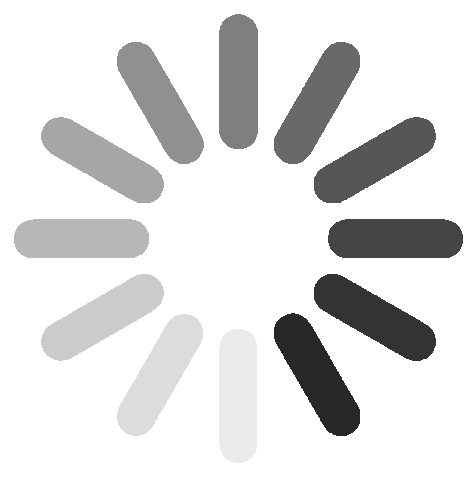

In [ ]:
plot

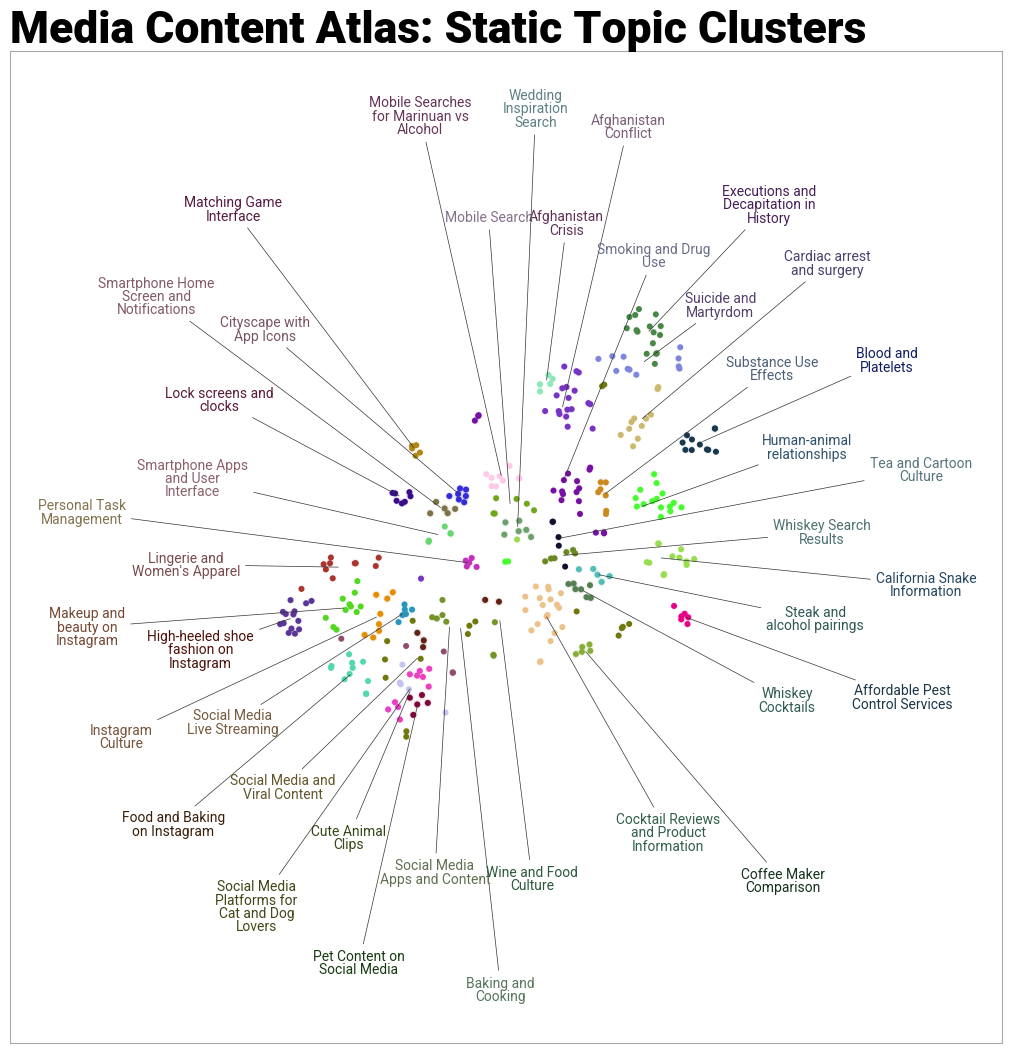

✅ Static plot saved to tutorial/MCA_static_topic_plot.png


In [ ]:
import datamapplot
import matplotlib.pyplot as plt

# === Make sure xy_tsne is a NumPy array of [x, y] pairs
data_map_coords = df[['x_tsne', 'y_tsne']].to_numpy()

# === Optional color mapping
colors_np = df['topic_name'].map(color_mapping).to_numpy()

# === Create the static plot
fig, _ = datamapplot.create_plot(
    data_map_coords=data_map_coords,
    labels=df['topic_name'].tolist(),
    marker_color_array=colors_np,
    title="Media Content Atlas: Static Topic Clusters",
    label_font_size=10
)

# === Save and show
fig.savefig("tutorial/MCA_static_topic_plot.png", dpi=300, bbox_inches="tight")
plt.show()
print("✅ Static plot saved to tutorial/MCA_static_topic_plot.png")

* Added late-night usage analysis: Counts how often users access their phone between 9 PM and 3 AM to assess nighttime device use, which can affect sleep.

* Calculated first daily usage time: Finds the earliest phone usage each day as a proxy for wake-up time.- what time they first use their phones each day (wake-up time)

* Computed sleep variability: Measures how consistent or inconsistent wake-up times are across days by calculating the standard deviation of daily first usage times.- Measures how much their wake-up times change

* Calculated late-night to daytime usage ratio: Compares night vs. day usage to identify possible digital wellbeing concerns related to nighttime overuse.

* Tagged potentially harmful content: Checks descriptions for keywords indicating sadness, violence, or other negative content to analyze exposure to topics that might impact mental health. - analyze if something could potentially hurt their mental health

LATEST

In [ ]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Load and clean dataset ===
df = pd.read_csv("tutorial/llava_topic_labeled_tsne.csv")
df = df.dropna(subset=['filename', 'topic_name', 'description'])

# === Extract timestamp from filename ===
def extract_timestamp(filename):
    ts_str = filename[:17]
    return datetime.strptime(ts_str, "%Y%m%d%H%M%S%f")

df['timestamp'] = df['filename'].apply(extract_timestamp)
df['time_only'] = df['timestamp'].dt.strftime('%H:%M')
df['date_only'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df['hour'] = df['timestamp'].dt.hour

# === Define time periods ===
def time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(time_period)
df['time_period'] = pd.Categorical(df['time_period'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

# === Semantic similarity-based harmful detection ===
harmful_keywords = [
    'sad', 'cry', 'depress', 'alone', 'breakup', 'hurt', 'pain',
    'kill', 'fight', 'weapon', 'assault', 'abuse',
    'suicide', 'self harm', 'overdose'
]

vectorizer = TfidfVectorizer(stop_words='english')
corpus = df['description'].astype(str).tolist() + harmful_keywords
tfidf_matrix = vectorizer.fit_transform(corpus)
similarity_matrix = cosine_similarity(tfidf_matrix[:-len(harmful_keywords)], tfidf_matrix[-len(harmful_keywords):])
df['harmful_score'] = similarity_matrix.max(axis=1)
df['is_concerning'] = df['harmful_score'] > 0.3
df['high_risk'] = ((df['hour'] >= 21) | (df['hour'] < 3)) & (df['harmful_score'] > 0.3) | (df['harmful_score'] >= 0.5)

def concern_level(row):
    if row['high_risk']:
        return 'High Concern'
    elif row['is_concerning']:
        return 'Concerning'
    else:
        return 'Normal'

df['concern_level'] = df.apply(concern_level, axis=1)

# === Hover text ===
df['hover_text'] = df.apply(
    lambda row: f"📅 Date: {row['date_only']}<br>⏰ Time: {row['time_only']}<br>📌 Topic: {row['topic_name']}<br>🕒 Period: {row['time_period']}<br>⚠️ Similarity Score: {row['harmful_score']:.2f}<br>🚨 Risk Level: {row['concern_level']}",
    axis=1
)

# === Adjust for single-day datasets ===
if df['date_only'].nunique() == 1:
    df['time_period'] = 'All Day'

# === Create scatter plot ===
g = px.scatter(
    df,
    x='time_only',
    y='date_only',
    color='concern_level',
    symbol='topic_name',
    animation_frame=None if df['time_period'].nunique() == 1 else 'time_period',
    hover_name='hover_text',
    opacity=0.9,
    title="🧠 Behavioral Sensor: Screenshot Activity by Date",
    width=1300,
    height=850,
    color_discrete_map={
        'Normal': '#1f77b4',
        'Concerning': '#ff7f0e',
        'High Concern': '#d62728'
    }
)

g.update_traces(marker=dict(size=12, line=dict(width=1, color='black')))
g.update_layout(
    xaxis_title="Time (HH:MM)",
    yaxis_title="Date (YYYY-MM-DD)",
    yaxis=dict(categoryorder='category ascending'),
    xaxis=dict(tickangle=45, type='category'),
    legend_title="🔍 Concern Level + 🧩 Topic Symbol",
    font=dict(size=12),
    margin=dict(r=400, b=100)  # Add space to right and bottom
)

# === Add concern level guide outside and below legend ===
g.add_annotation(
    text=(
        "<b>Concern Level Guide:</b><br>"
        "🔵 <b>Normal</b>: No risk<br>"
        "🟠 <b>Concerning</b>: Mild similarity to harmful terms<br>"
        "🔴 <b>High Concern</b>: Strong match or late-night usage"
    ),
    xref="paper", yref="paper",
    x=1.42,   # Far right
    y=0.3,  # Below plot area
    showarrow=False,
    align="left",
    bordercolor="black",
    borderwidth=1,
    bgcolor="white",
    opacity=0.95
)

# === Summary stats ===
summary_stats = {
    "Total Screenshots": len(df),
    "Unique Topics": df['topic_name'].nunique(),
    "Date Range": df['date_only'].min() if df['date_only'].nunique() == 1 else f"{df['date_only'].min()} → {df['date_only'].max()}",
    "High Concern Count": (df['concern_level'] == 'High Concern').sum(),
    "Concerning Count": (df['concern_level'] == 'Concerning').sum(),
    "Normal Count": (df['concern_level'] == 'Normal').sum(),
    "Nighttime Screenshots (9PM–3AM)": ((df['hour'] >= 21) | (df['hour'] < 3)).sum()
}

print("\n📊 Behavioral Summary")
for k, v in summary_stats.items():
    print(f"• {k}: {v}")

# === Save and display ===
g.write_html("tutorial/behavioral_sensor_final.html")
g.show()



📊 Behavioral Summary
• Total Screenshots: 353
• Unique Topics: 39
• Date Range: 2021-08-17 → 2021-08-23
• High Concern Count: 2
• Concerning Count: 3
• Normal Count: 348
• Nighttime Screenshots (9PM–3AM): 46


In [ ]:
import pandas as pd
import plotly.express as px
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Load dataset ===
df = pd.read_csv("tutorial/llava_topic_labeled_tsne.csv")
df = df.dropna(subset=['topic_name', 'filename', 'description'])

# === Extract timestamp from filename ===
def extract_timestamp(filename):
    ts_str = filename[:17]
    return datetime.strptime(ts_str, "%Y%m%d%H%M%S%f")

df['timestamp'] = df['filename'].apply(extract_timestamp)
df['hour'] = df['timestamp'].dt.hour

# === Classify into time periods ===
def time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_period'] = df['hour'].apply(time_period)
df['time_period'] = pd.Categorical(df['time_period'], categories=['Morning', 'Afternoon', 'Evening', 'Night'], ordered=True)

# === Top 5 topics by count ===
top_topics = df['topic_name'].value_counts().nlargest(5).reset_index()
top_topics.columns = ['topic_name', 'count']

# === Behavioral Insights ===
df_top = df[df['topic_name'].isin(top_topics['topic_name'])]

def safe_idxmax(series):
    return series.value_counts().idxmax() if not series.empty else "N/A"

top_topic_per_period = df_top.groupby('time_period', observed=True)['topic_name'].agg(safe_idxmax)
most_consistent_topic = df_top.groupby('topic_name')['time_period'].nunique().idxmin()
most_night_topic = df_top[df_top['time_period'] == 'Night']['topic_name'].value_counts().idxmax()

print("\n🧠 Insights (Top 5 Topics Only):")
print(f"• Most Active Topic in Morning: {top_topic_per_period.get('Morning', 'N/A')}")
print(f"• Most Active Topic in Afternoon: {top_topic_per_period.get('Afternoon', 'N/A')}")
print(f"• Most Active Topic in Evening: {top_topic_per_period.get('Evening', 'N/A')}")
print(f"• Most Active Topic at Night: {top_topic_per_period.get('Night', 'N/A')}")
print(f"• Most Consistent Topic (Least Time Variation): {most_consistent_topic}")
print(f"• Most Night-Visited Topic: {most_night_topic}")

# === Topic occurrence table (Top 5) ===
print("\n📋 Top 5 Topic Occurrences:")
print(top_topics.to_string(index=False))

# === Mental health concern detection ===
mental_keywords = [
    'sad', 'cry', 'depress', 'alone', 'breakup', 'hurt', 'pain',
    'kill', 'fight', 'weapon', 'assault', 'abuse',
    'suicide', 'self harm', 'overdose'
]

vectorizer = TfidfVectorizer(stop_words='english')
corpus_mental = df['description'].astype(str).tolist() + mental_keywords
tfidf_mental = vectorizer.fit_transform(corpus_mental)
similarity_mental = cosine_similarity(tfidf_mental[:-len(mental_keywords)], tfidf_mental[-len(mental_keywords):])
df['mental_score'] = similarity_mental.max(axis=1)
df['mental_concern'] = df['mental_score'] > 0.3

# === Physical health concern detection ===
physical_keywords = [
    'alcohol', 'drunk', 'hangover', 'wine', 'beer', 'vodka', 'whiskey',
    'smoke', 'smoking', 'cigarette', 'vape', 'weed', 'marijuana',
    'addiction', 'substance', 'intoxicated', 'overdose'
]

corpus_physical = df['description'].astype(str).tolist() + physical_keywords
tfidf_physical = vectorizer.fit_transform(corpus_physical)
similarity_physical = cosine_similarity(tfidf_physical[:-len(physical_keywords)], tfidf_physical[-len(physical_keywords):])
df['physical_score'] = similarity_physical.max(axis=1)
df['physical_concern'] = df['physical_score'] > 0.3

# === Concern summaries ===
mental_count = df['mental_concern'].sum()
physical_count = df['physical_concern'].sum()

print("\n🚨 Concern Summary:")
print(f"• Potential Mental Health Flags: {mental_count}")
print(f"• Potential Physical Health Flags (e.g., alcohol/smoking): {physical_count}")

# === Pie chart ===
fig = px.pie(
    top_topics,
    names='topic_name',
    values='count',
    title="Top 5 Most Visited Topics",
    color_discrete_sequence=px.colors.sequential.RdBu
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(showlegend=True)
fig.write_html("tutorial/top_5_topics_pie.html")
fig.show()



🧠 Insights (Top 5 Topics Only):
• Most Active Topic in Morning: N/A
• Most Active Topic in Afternoon: Afghanistan Conflict
• Most Active Topic in Evening: Cocktail Reviews and Product Information
• Most Active Topic at Night: Smoking and Drug Use
• Most Consistent Topic (Least Time Variation): Cocktail Reviews and Product Information
• Most Night-Visited Topic: Smoking and Drug Use

📋 Top 5 Topic Occurrences:
                              topic_name  count
Cocktail Reviews and Product Information     20
                    Afghanistan Conflict     19
                    Smoking and Drug Use     19
              Human-animal relationships     17
                   Wine and Food Culture     17

🚨 Concern Summary:
• Potential Mental Health Flags: 5
• Potential Physical Health Flags (e.g., alcohol/smoking): 20


Allows researchers/whoevers using this platoform to compare usage patterns across weekdays vs weekends

In [ ]:
import pandas as pd
import plotly.express as px

# Day of week column
df['day_of_week'] = df['timestamp'].dt.day_name()

# Group by day and topic
dow_df = df.groupby(['day_of_week', 'topic_name']).size().reset_index(name='count')

# Sort days
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_df['day_of_week'] = pd.Categorical(dow_df['day_of_week'], categories=dow_order, ordered=True)

# Plot
fig = px.bar(
    dow_df,
    x='day_of_week',
    y='count',
    color='topic_name',
    title='Topic Access Frequency by Day of Week',
    labels={'count': 'Access Count', 'day_of_week': 'Day of Week'},
    barmode='group',
    color_discrete_sequence=px.colors.qualitative.Bold,
    height=600
)
fig.show()


The following code works but has a random/test data set.

---



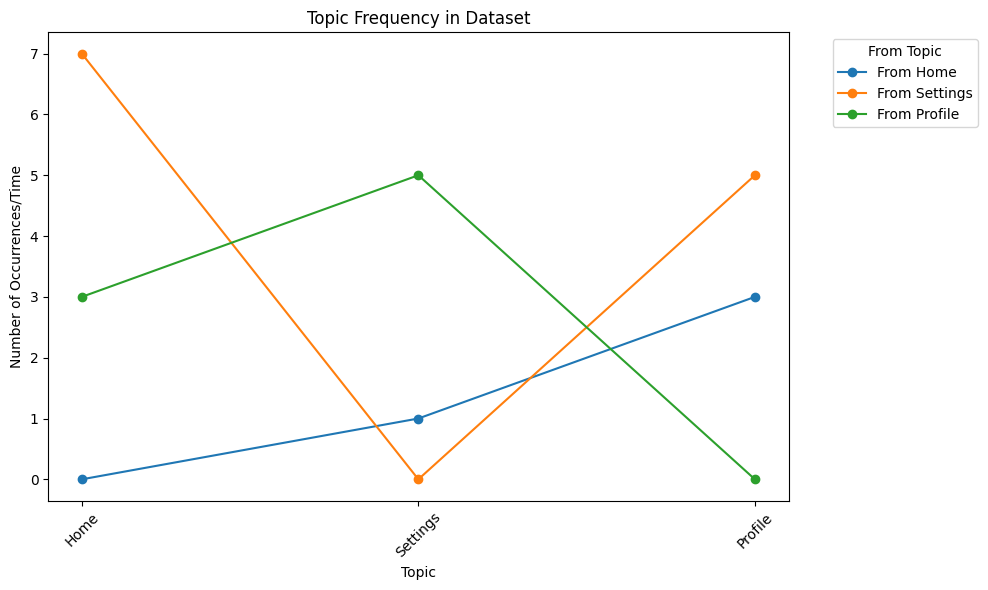

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# === Sample data_json as placeholder (define or load this before using) ===
data_json = {
    "distancematrix": [
        [0, 1.0, 3.0],
        [7.0, 0, 5.0],
        [3.0, 5.0, 0]
    ],
    "data": [
        {
            "name": "name1",
            "timelabels": [
                "2014-02-21 00:00:00.0",
                "2014-02-22 00:00:00.0",
                "2014-02-23 00:00:00.0"
            ]
        }
    ]
}

# === Random topics ===
topics = ["Home", "Settings", "Profile"]

# === Convert distancematrix to DataFrame with topics as columns and rows ===
df = pd.DataFrame(data_json['distancematrix'], columns=topics, index=topics)

# === Plot line graph with x-axis as topics ===
plt.figure(figsize=(10,6))

for idx, row in df.iterrows():
    plt.plot(df.columns, row.values, marker='o', label=f"From {idx}")

plt.xlabel("Topic")
plt.ylabel("Number of Occurrences/Time")
plt.title("Topic Frequency in Dataset")
plt.legend(title="From Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Retrieve Images based on queries

Retrieval results depend on both the starting dataset and the retrieval parameters you set, such as the similarity cutoff or top-k. Adjust these settings based on your needs. If you have ground truth labels for your use case, you can also evaluate performance by calculating precision and recall@k.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# === Load LLAVA and CLIP embedding models
text_embed_model = SentenceTransformer("Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True, device='cuda')
clip_model = SentenceTransformer("clip-ViT-L-14", trust_remote_code=True, device='cuda')

# === live_query function
def live_query(text_embed_model, clip_model, query, llava_embeddings, clip_embeddings, top_k=5):
    # Encode query
    query_embed_llava = torch.tensor(text_embed_model.encode(query), device='cuda')
    query_embed_clip = torch.tensor(clip_model.encode(query), device='cuda')

    # Similarity to LLAVA
    llava_sims = {
        fname: torch.nn.functional.cosine_similarity(query_embed_llava, emb, dim=0).item()
        for fname, emb in llava_embeddings.items()
    }
    llava_top = sorted(llava_sims.items(), key=lambda x: x[1], reverse=True)[:top_k]

    # Similarity to CLIP
    clip_sims = {
        fname: torch.nn.functional.cosine_similarity(query_embed_clip, emb, dim=0).item()
        for fname, emb in clip_embeddings.items()
    }
    clip_top = sorted(clip_sims.items(), key=lambda x: x[1], reverse=True)[:top_k]

    # Normalize
    def normalize(scores):
        vals = np.array(list(scores.values())).reshape(-1, 1)
        norm_vals = MinMaxScaler().fit_transform(vals).flatten()
        return {k: v for k, v in zip(scores.keys(), norm_vals)}

    return {
        'llava': {
            fname: {
                'similarity': llava_sims[fname],
                'normalized': normalize(llava_sims)[fname]
            } for fname, _ in llava_top
        },
        'clip': {
            fname: {
                'similarity': clip_sims[fname],
                'normalized': normalize(clip_sims)[fname]
            } for fname, _ in clip_top
        }
    }

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/354 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import torch
import numpy as np

def load_embeddings_npz(npz_path, to_cuda=True):
    """
    Load embeddings from a .npz file containing 'filenames' and 'embeddings' arrays.
    Returns a dictionary: {filename: embedding_tensor}
    """
    print(f"📂 Loading embeddings from {npz_path}...")
    data = np.load(npz_path, allow_pickle=True)
    filenames = data['filenames']
    embeddings = data['embeddings']
    if to_cuda:
        embeddings = torch.tensor(embeddings, device='cuda')
    embeddings_dict = {fname: emb for fname, emb in zip(filenames, embeddings)}
    print(f"✅ Loaded {len(embeddings_dict)} embeddings from {npz_path}")
    return embeddings_dict

# === Paths to your saved files
llava_npz_path = "tutorial/llava_embeddings.npz"
clip_npz_path = "tutorial/clip_embeddings.npz"

# === Load both
llava_embeddings = load_embeddings_npz(llava_npz_path)
clip_embeddings = load_embeddings_npz(clip_npz_path)

📂 Loading embeddings from tutorial/llava_embeddings.npz...
✅ Loaded 353 embeddings from tutorial/llava_embeddings.npz
📂 Loading embeddings from tutorial/clip_embeddings.npz...
✅ Loaded 353 embeddings from tutorial/clip_embeddings.npz



🔎 Query: cats

📌 LLAVA:
  • 20210823180653896.jpg — sim: 0.6598, norm: 1.0000
  • 20210823180603884.jpg — sim: 0.6588, norm: 0.9973
  • 20210823180618888.jpg — sim: 0.6437, norm: 0.9568

📌 CLIP:
  • 20210823180708900.jpg — sim: 0.2184, norm: 1.0000
  • 20210823180618888.jpg — sim: 0.2171, norm: 0.9909
  • 20210823180628891.jpg — sim: 0.2122, norm: 0.9585
💾 Saved to: retrieval_outputs/20250425_023216_cats.json


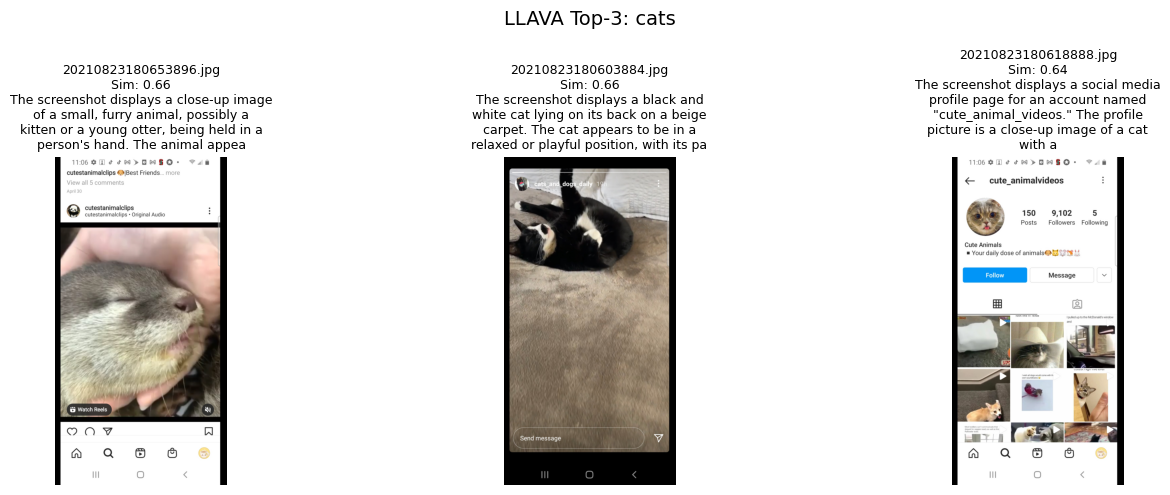

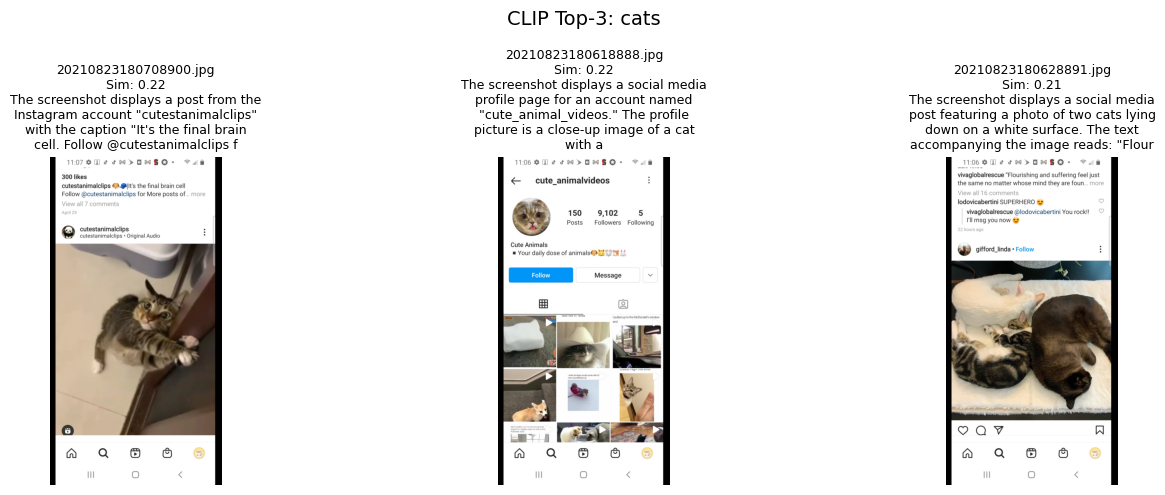


🔎 Query: violence

📌 LLAVA:
  • 20210823180138774.jpg — sim: 0.6490, norm: 1.0000
  • 20210823180128769.jpg — sim: 0.6356, norm: 0.9597
  • 20210823180853954.jpg — sim: 0.6285, norm: 0.9383

📌 CLIP:
  • 20210823180208794.jpg — sim: 0.2284, norm: 1.0000
  • 20210823180048752.jpg — sim: 0.2266, norm: 0.9874
  • 20210823180218797.jpg — sim: 0.2173, norm: 0.9217
💾 Saved to: retrieval_outputs/20250425_023218_violence.json


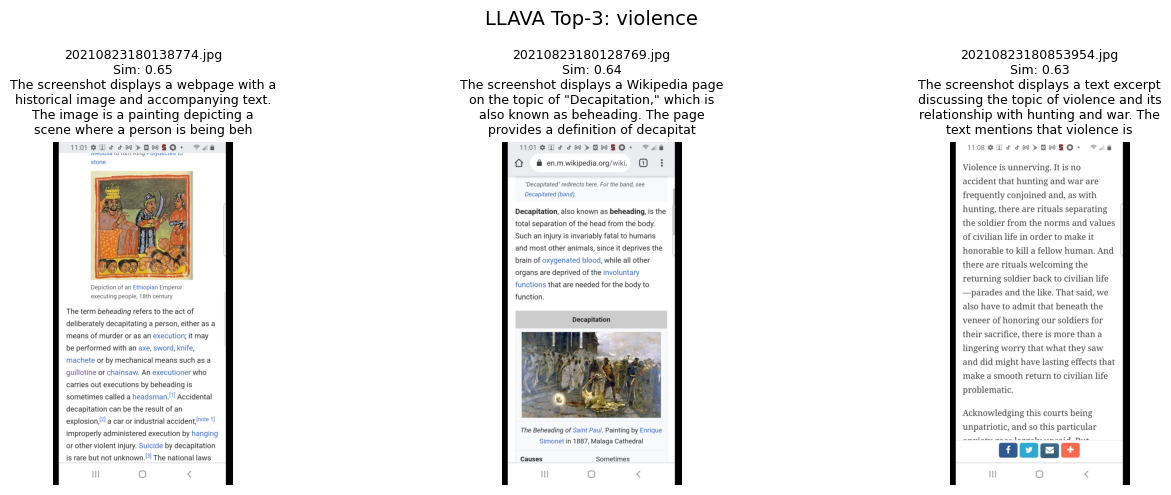

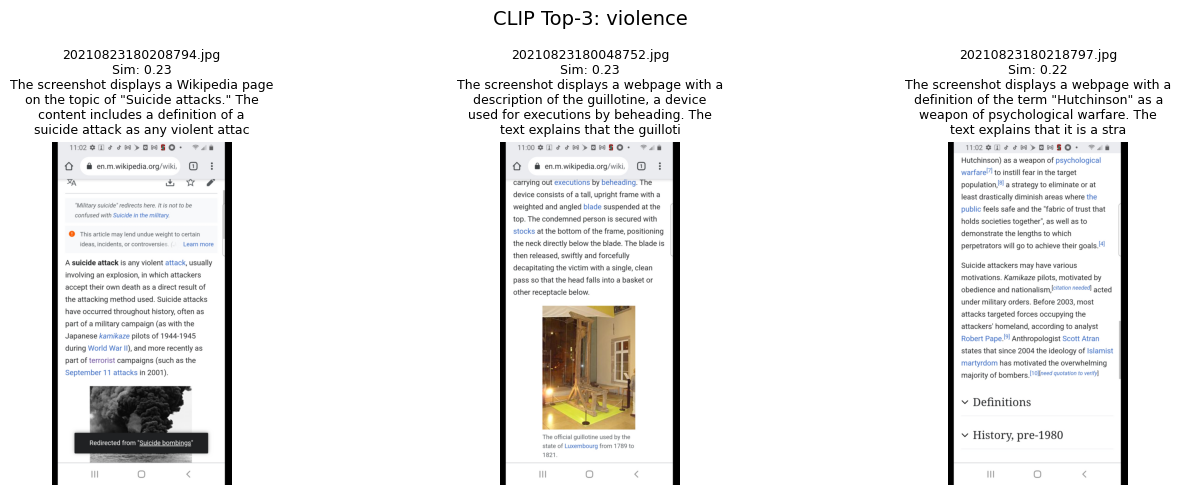


🔎 Query: food

📌 LLAVA:
  • 20210823172423747.jpg — sim: 0.6307, norm: 1.0000
  • 20210823172433750.jpg — sim: 0.6079, norm: 0.9376
  • 20210823165124011.jpg — sim: 0.5967, norm: 0.9068

📌 CLIP:
  • 20210823213833773.jpg — sim: 0.2076, norm: 1.0000
  • 20210823164003787.jpg — sim: 0.2055, norm: 0.9840
  • 20210823213723737.jpg — sim: 0.1998, norm: 0.9406
💾 Saved to: retrieval_outputs/20250425_023225_food.json


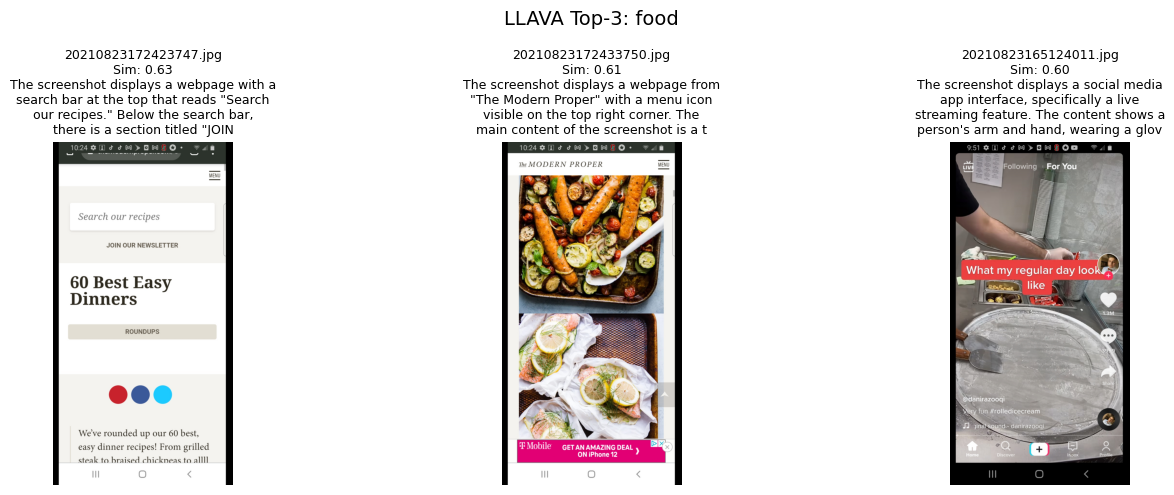

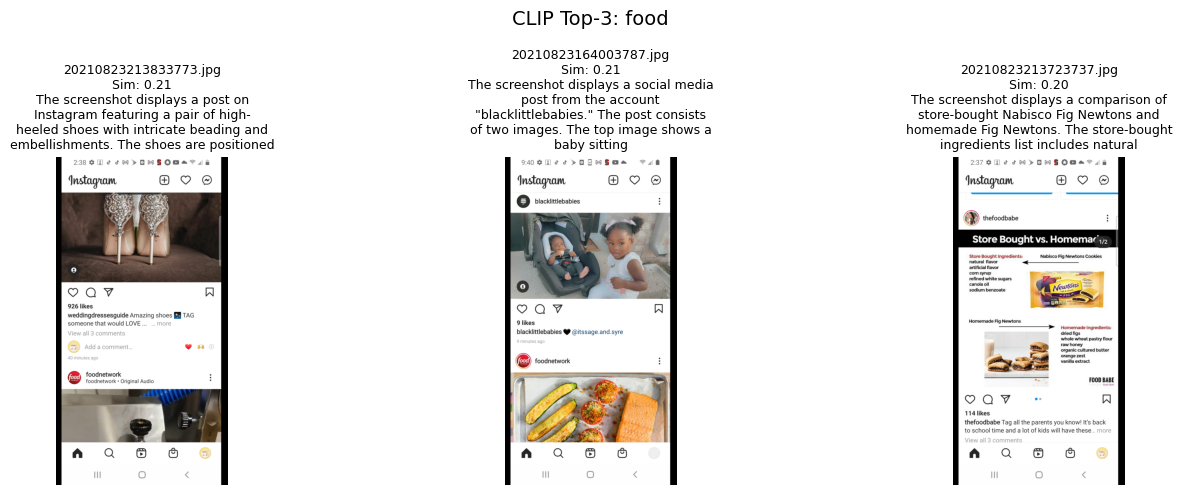


🔎 Query: political content

📌 LLAVA:
  • 20210823170048768.jpg — sim: 0.5310, norm: 1.0000
  • 20210823180008742.jpg — sim: 0.5188, norm: 0.9403
  • 20210823165933747.jpg — sim: 0.5124, norm: 0.9089

📌 CLIP:
  • 20210823170048768.jpg — sim: 0.2074, norm: 1.0000
  • 20210823180118766.jpg — sim: 0.2066, norm: 0.9939
  • 20210823165948751.jpg — sim: 0.2036, norm: 0.9701
💾 Saved to: retrieval_outputs/20250425_023229_political_content.json


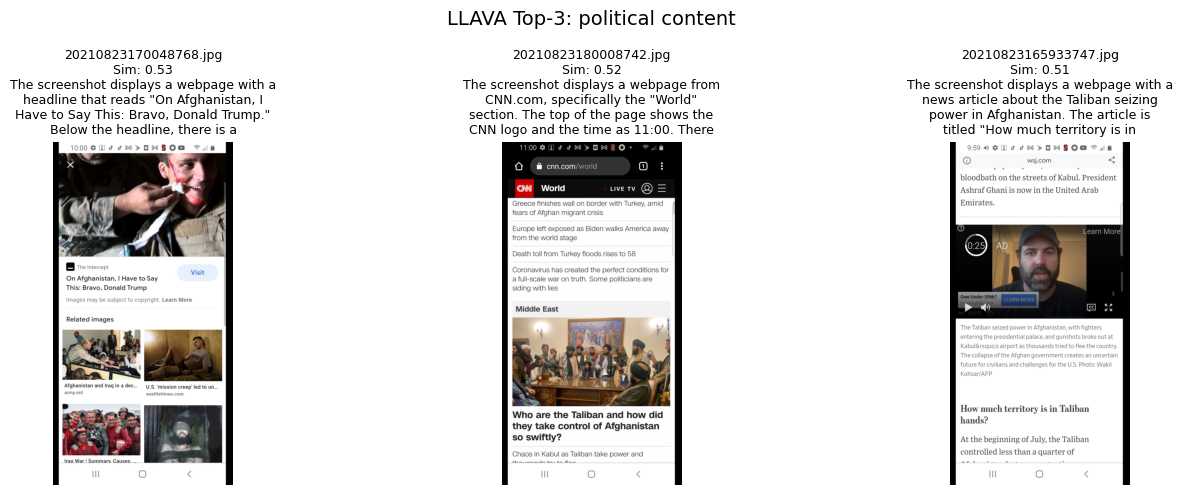

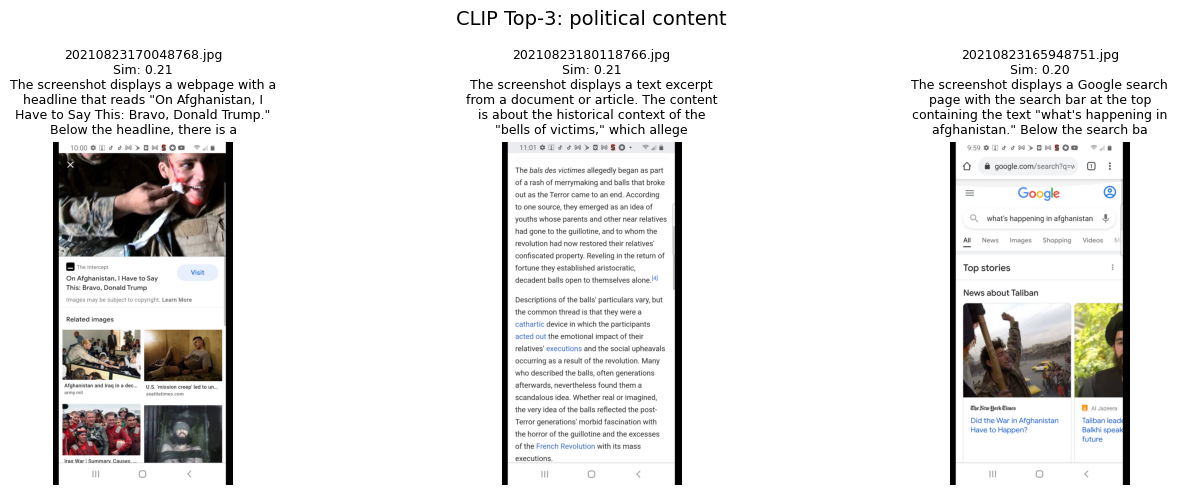


🔎 Query: substance use

📌 LLAVA:
  • 20210823172848818.jpg — sim: 0.6483, norm: 1.0000
  • 20210823172923825.jpg — sim: 0.6470, norm: 0.9963
  • 20210823173038850.jpg — sim: 0.6352, norm: 0.9617

📌 CLIP:
  • 20210823172928826.jpg — sim: 0.2424, norm: 1.0000
  • 20210823172848818.jpg — sim: 0.2394, norm: 0.9795
  • 20210823173043851.jpg — sim: 0.2227, norm: 0.8623
💾 Saved to: retrieval_outputs/20250425_023233_substance_use.json


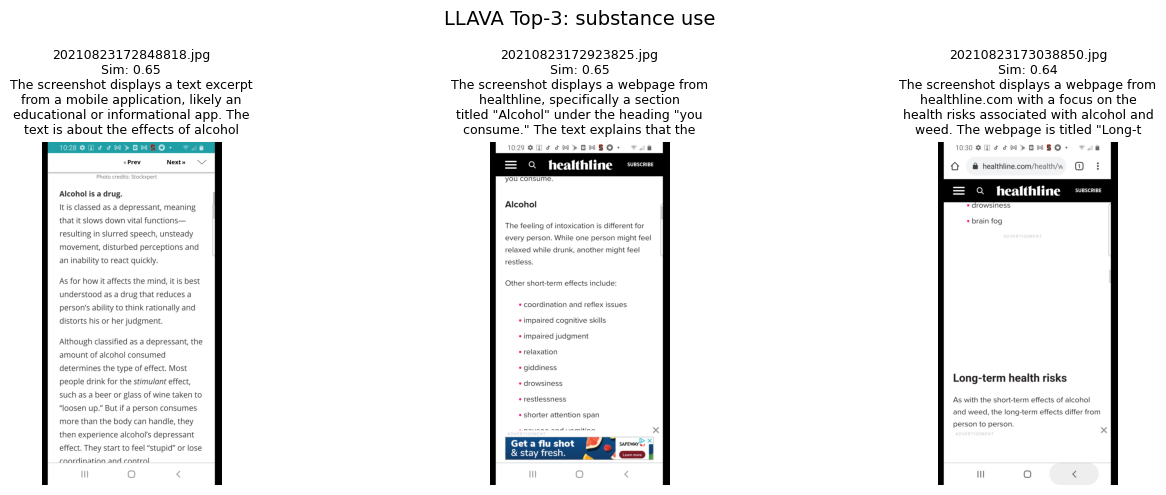

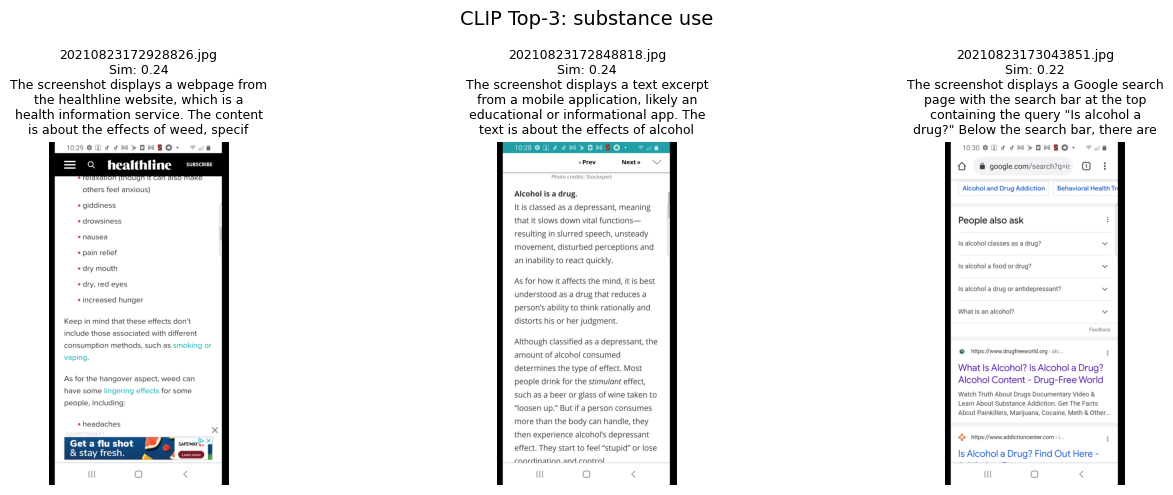


🔎 Query: body standards

📌 LLAVA:
  • 20210823165134012.jpg — sim: 0.5968, norm: 1.0000
  • 20210823180318814.jpg — sim: 0.5478, norm: 0.8614
  • 20210823164053801.jpg — sim: 0.5444, norm: 0.8518

📌 CLIP:
  • 20210823164143815.jpg — sim: 0.2122, norm: 1.0000
  • 20210823180918966.jpg — sim: 0.2021, norm: 0.9192
  • 20210823214243873.jpg — sim: 0.1960, norm: 0.8704
💾 Saved to: retrieval_outputs/20250425_023236_body_standards.json


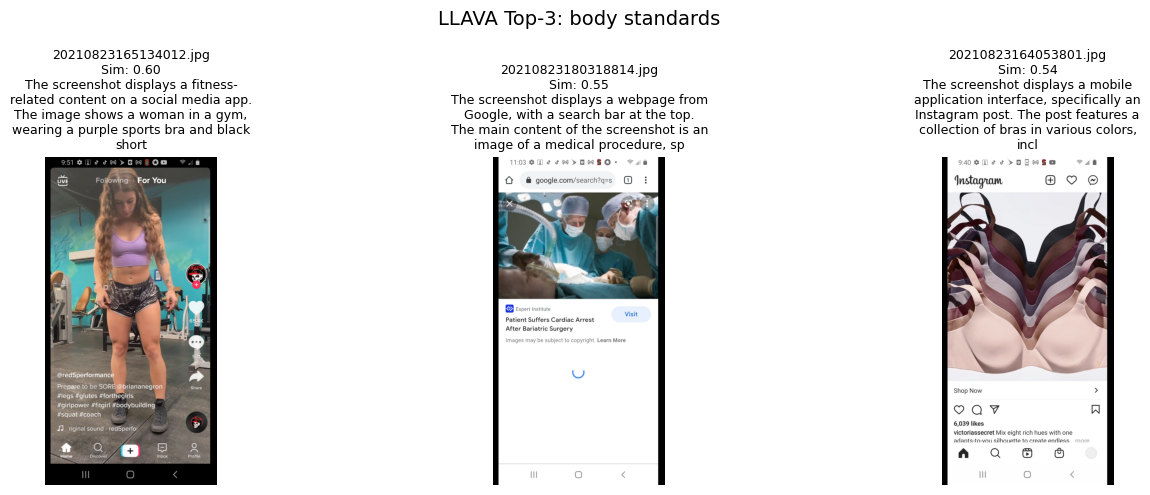

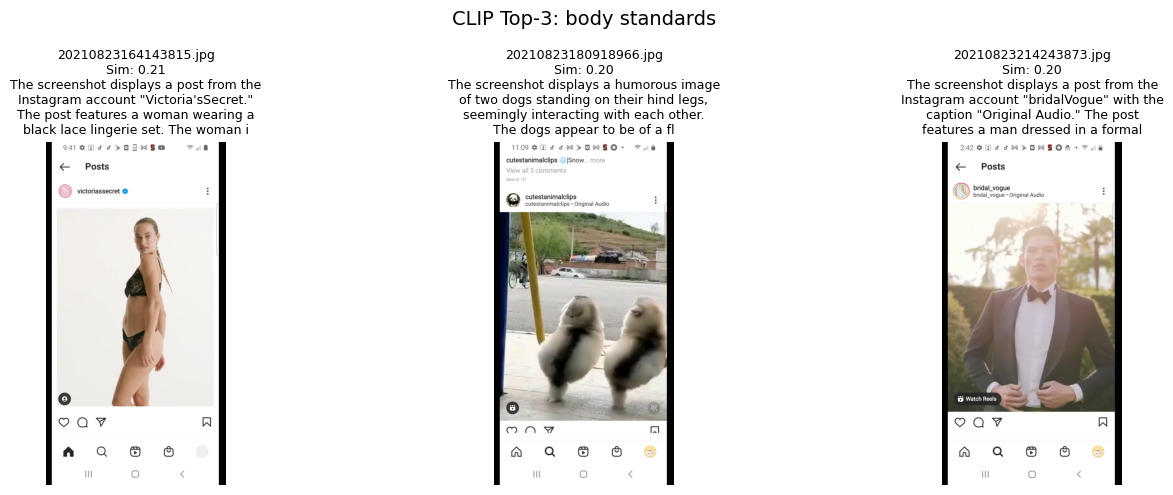


🔎 Query: suicide-related content

📌 LLAVA:
  • 20210823180228801.jpg — sim: 0.6080, norm: 1.0000
  • 20210823180148776.jpg — sim: 0.6068, norm: 0.9966
  • 20210823180158790.jpg — sim: 0.6037, norm: 0.9876

📌 CLIP:
  • 20210823180148776.jpg — sim: 0.2626, norm: 1.0000
  • 20210823180228801.jpg — sim: 0.2570, norm: 0.9628
  • 20210823180158790.jpg — sim: 0.2570, norm: 0.9624
💾 Saved to: retrieval_outputs/20250425_023239_suicide-related_content.json


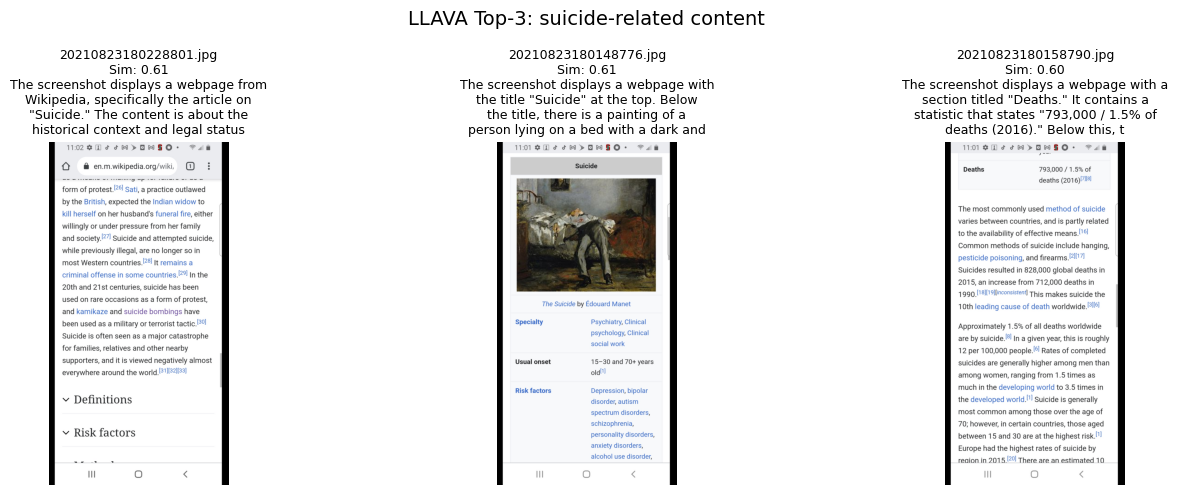

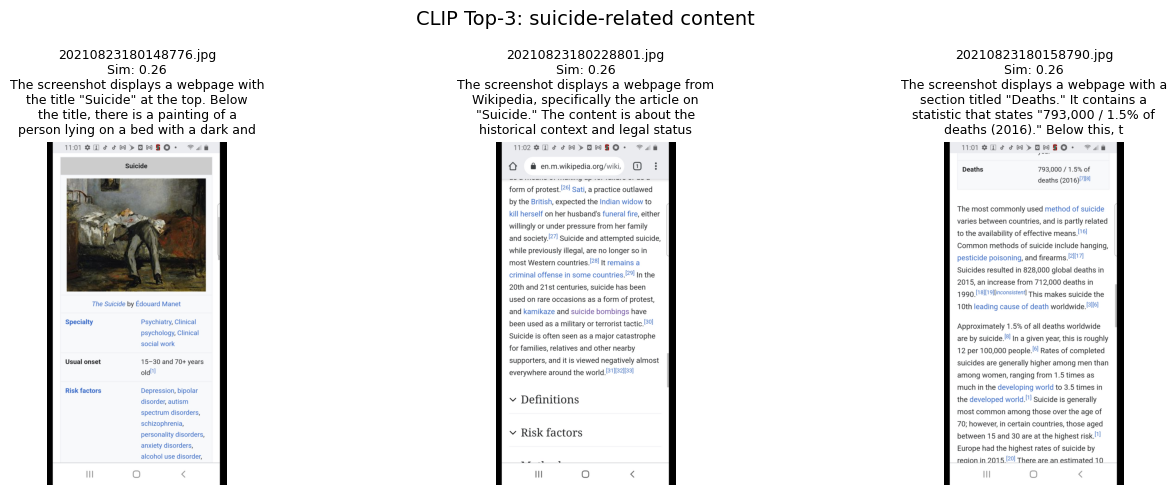


🔎 Query: blood

📌 LLAVA:
  • 20210823180403829.jpg — sim: 0.7197, norm: 1.0000
  • 20210823180413833.jpg — sim: 0.7181, norm: 0.9959
  • 20210823180358827.jpg — sim: 0.6771, norm: 0.8940

📌 CLIP:
  • 20210823180453861.jpg — sim: 0.2340, norm: 1.0000
  • 20210823180428839.jpg — sim: 0.2295, norm: 0.9689
  • 20210823180408832.jpg — sim: 0.2294, norm: 0.9679
💾 Saved to: retrieval_outputs/20250425_023242_blood.json


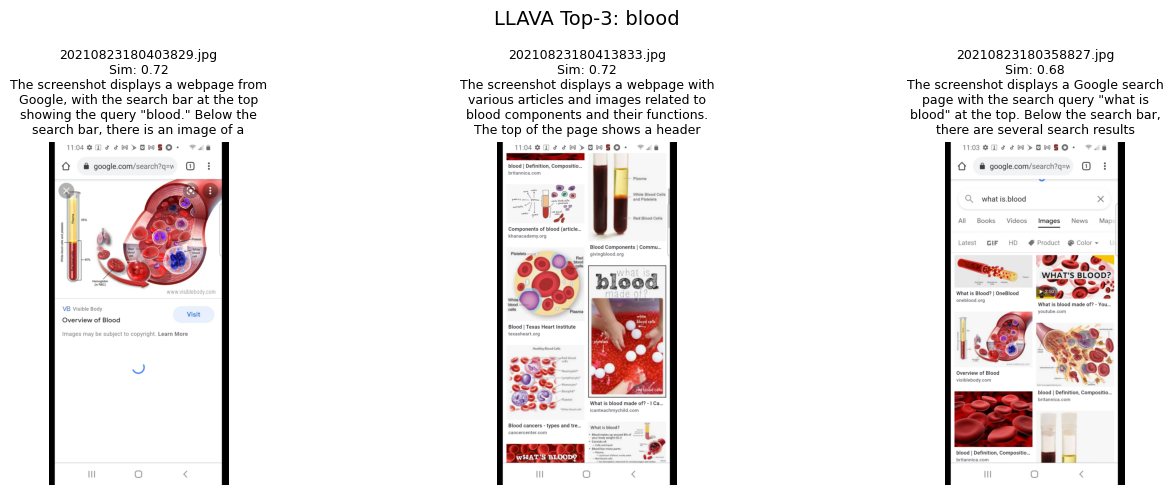

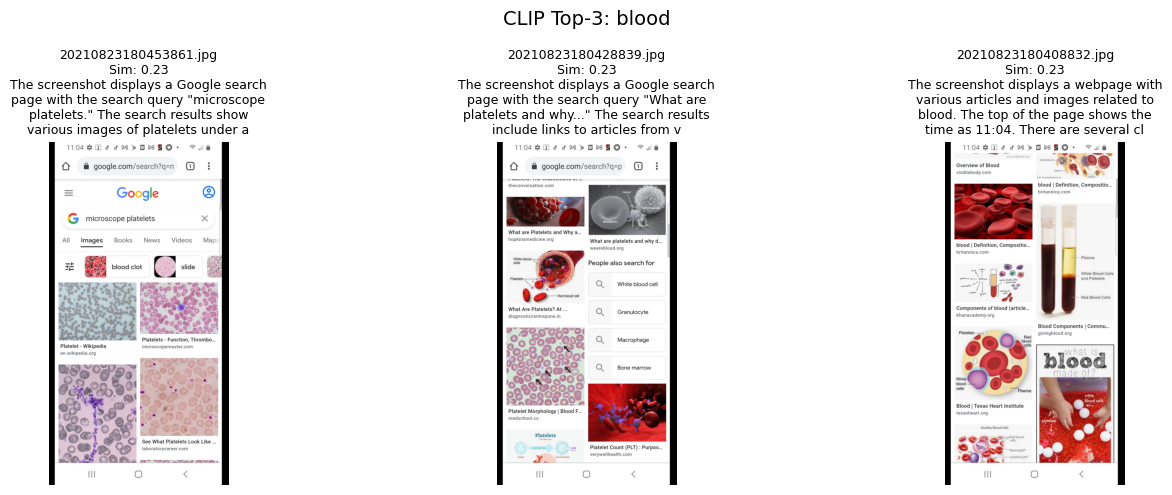


🔎 Query: happiness

📌 LLAVA:
  • 20210823213733741.jpg — sim: 0.5965, norm: 1.0000
  • 20210823175933732.jpg — sim: 0.5318, norm: 0.8419
  • 20210823195003764.jpg — sim: 0.5274, norm: 0.8312

📌 CLIP:
  • 20210823213733741.jpg — sim: 0.1832, norm: 1.0000
  • 20210823173028847.jpg — sim: 0.1805, norm: 0.9712
  • 20210823180638893.jpg — sim: 0.1783, norm: 0.9474
💾 Saved to: retrieval_outputs/20250425_023244_happiness.json


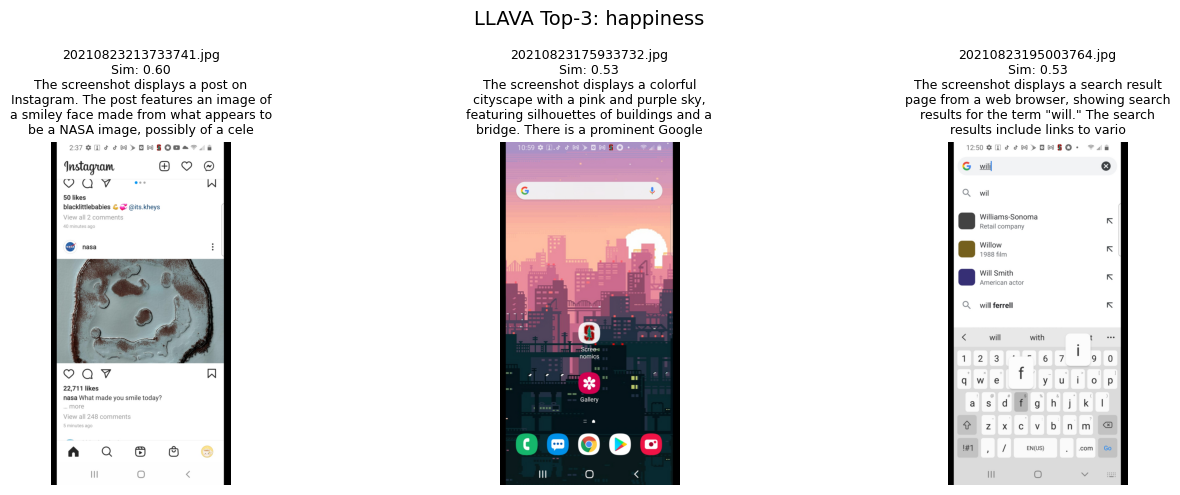

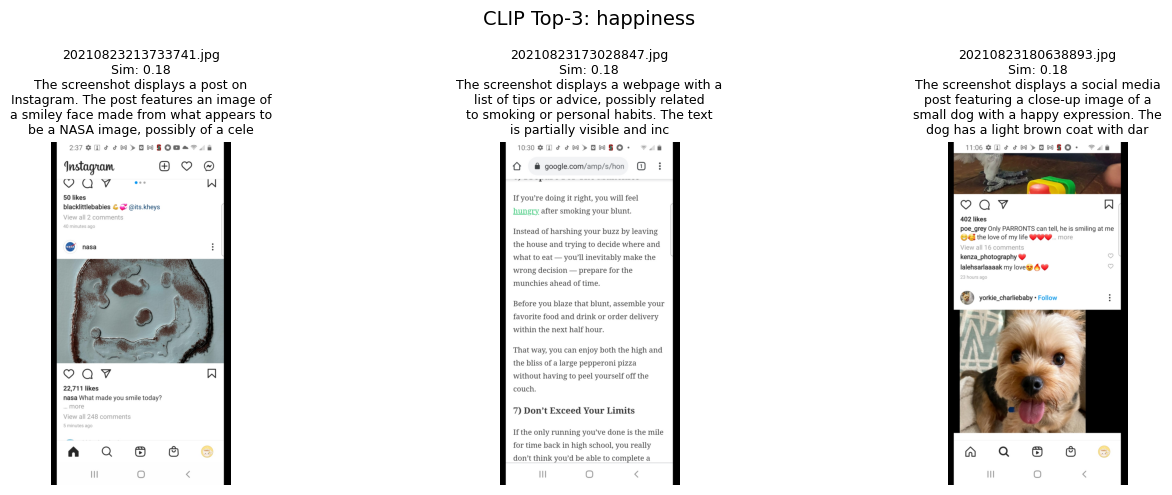

In [ ]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import pandas as pd
import textwrap

# === Config ===
image_folder = "tutorial/images"
output_folder = "retrieval_outputs"
description_csv = "tutorial/llava_descriptions.csv"
top_k = 3  # Change this to control how many results to show
queries = ["cats",
           "violence",
           "food",
           "political content",
           "substance use",
           "body standards",
           "suicide-related content",
           "blood",
           "happiness"]

# === Load descriptions
desc_df = pd.read_csv(description_csv)
desc_dict = dict(zip(desc_df['filename'], desc_df['description']))

# === Create output directory
os.makedirs(output_folder, exist_ok=True)

# === Show images + description
def show_top_images_with_descriptions(filenames, title, similarities):
    n = len(filenames)
    plt.figure(figsize=(5 * n, 5))
    for i, fname in enumerate(filenames):
        path = os.path.join(image_folder, fname)
        try:
            img = Image.open(path).convert("RGB")
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis('off')
            sim = similarities[fname]
            description = desc_dict.get(fname, "(No description found)")[:150]
            wrapped = textwrap.fill(description, width=40)
            plt.title(f"{fname}\nSim: {sim:.2f}\n{wrapped}", fontsize=9)
        except FileNotFoundError:
            print(f"⚠️ File not found: {fname}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# === Batch loop
for query in queries:
    print(f"\n🔎 Query: {query}")
    results = live_query(
        text_embed_model, clip_model,
        query,
        llava_embeddings, clip_embeddings,
        top_k=top_k
    )

    # Print matches
    print("\n📌 LLAVA:")
    for fname, scores in results['llava'].items():
        print(f"  • {fname} — sim: {scores['similarity']:.4f}, norm: {scores['normalized']:.4f}")

    print("\n📌 CLIP:")
    for fname, scores in results['clip'].items():
        print(f"  • {fname} — sim: {scores['similarity']:.4f}, norm: {scores['normalized']:.4f}")

    # Save JSON
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    safe_query = query.lower().replace(" ", "_").replace("/", "_")[:50]
    json_path = os.path.join(output_folder, f"{timestamp}_{safe_query}.json")
    with open(json_path, "w") as f:
        json.dump({"query": query, "results": results}, f, indent=4)
    print(f"💾 Saved to: {json_path}")

    # Show visual + descriptions
    show_top_images_with_descriptions(
        list(results['llava'].keys()),
        f"LLAVA Top-{top_k}: {query}",
        {k: v['similarity'] for k, v in results['llava'].items()}
    )

    show_top_images_with_descriptions(
        list(results['clip'].keys()),
        f"CLIP Top-{top_k}: {query}",
        {k: v['similarity'] for k, v in results['clip'].items()}
    )

## 🥳 You've Reached the End!




Thanks for following along! If you’d like to scale this pipeline to larger datasets, start by checking out our [GitHub repo](https://github.com/mediacontentatlas/mediacontentatlas). You can open an issue there or email me directly at mervecer@stanford.edu if you have questions.

If you use this code or build on this idea in your work, please cite us:

> Cerit, M., Zelikman, E., Cho, M., Robinson, T. N., Reeves, B., Ram, N., & Haber, N. (2025). Media Content Atlas: A Pipeline to Explore and Investigate Multidimensional Media Space using Multimodal LLMs.
In Extended Abstracts of the CHI Conference on Human Factors in Computing Systems (CHI EA ’25). ACM.
https://doi.org/10.1145/3706599.3720055

If you use the sample data that is shared here, in your work, please cite this paper as well:

> Rocklin, M. L., Garròn Torres, A. A., Reeves, B., Robinson, T. N., & Ram, N. (2023). The affective dynamics of everyday digital life: Opening computational possibility. Affective Science, 4(3), 529-540.

And if you’re interested in collaborating, I’d love to hear from you!

Thanks again for exploring Media Content Atlas! 🚀